# 用pytorch实现一个简单的图卷积神经网络

采用networkx中自带的数据集来实现，Zachary karate club空手道俱乐部社会网络图，包含34个结点和78条边

In [1]:
import networkx as nx

In [4]:
G=nx.karate_club_graph()
print(G.number_of_nodes())
print(G.number_of_edges())

34
78


In [65]:
G

### GCN介绍

跟CNN网络一样，GCN原理也是利用堆叠一定的卷积层来实现，层与层之间也有激活函数。
1. 首先介绍拉普拉斯矩阵，定义为
$$L=D-A$$
其中A为图的邻接矩阵，D为图的度矩阵
$$D=\left\{\begin{matrix}结点i的度,i=j\\0,otherwise \end{matrix}\right.$$
其泛化拉普拉斯矩阵可以表示为
$$L_g=D^{-1/2}LD^{-1/2}= I-D^{-1/2}AD^{-1/2}$$
其中I为单位矩阵     
为了增强网络的稳定性，归一化拉普拉斯矩阵，表达式为：
$$L_g=L_g+I$$
因此图卷积层可以表示为
$$X=\sigma(L_gXW)$$

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.nn.init as init

In [7]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

#### 拉普拉斯归一化操作

In [8]:
def lap_norm(adj):
    #需要一个A，D
    adj += np.eye(adj.shape[0])
    degree = np.array(adj.sum(1))
    degree = np.diag(np.power(degree,-0.5))
    norm = degree.dot(adj).dot(degree)
    return norm

#### 卷积层设计

In [12]:
class GC(nn.Moudle):
    def __init__(self,input_size,output_size):
        super(GC,self).__init__()
        self.linear=nn.Linear(input_size,output_size)
        
    def forward(self,adj,features):
        out=torch.mm(adj,features)
        out=self.linear(out)
        return out     
    

In [68]:
#不用Lineaer模块进行实现代码
class GC_v2(nn.Module):
    def __init__(self,input_size,output_size,dropout,bias=True):
        super(GC_v2,self).__init__()
        self.input_size=input_size
        self.output_size=output_size
        self.dropout=dropout
        self.weight=nn.Parameter(torch.Tensor(input_size,output_size))
        nn.init.xavier_normal_(self.weight)
        if bias:
            self.bias=nn.Parameter(torch.Tensor(output_size))
            nn.init.xavier_normal_(self.bias)
        else:
            self.register_parameter('bias',None)
                                    
    def forward(self,adj,features):
        support=torch.mm(self.dropout(features),self.weight)
        out=torch.spmm(adj,support)
        if self.bias is not None:
            return out+self.bias
        else:
            return out

In [54]:
class GCN(nn.Module):
    def __init__(self,in_dim=34,hid_dim=5):
        super(GCN,self).__init__()
        self.gcn1 = GC(in_dim,hid_dim)
        self.gcn2 = GC(hid_dim,2)
    
    def forward(self,adj,features):
        out=self.gcn1(adj,features)
        out=self.gcn2(adj,out)
        return out    

#### 训练参数

In [31]:
learning_rate=0.1
weight_dacay=5e-4
epoches=50
device='cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
G.nodes[1]['club']

'Mr. Hi'

#### 训练数据准备

In [37]:
features=np.eye(34,dtype=np.float) #转化成one-hot数组

y= np.zeros(G.number_of_nodes())

for i in range(G.number_of_nodes()):
    if G.nodes[i]['club']=='Mr. Hi':
        y[i]=0
    else:
        y[i]=1
        
adj = np.zeros((34,34))
for k,v in G.adj.items():
    for item in v.keys():
        adj[k][item]=1
adj=lap_norm(adj)
        

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


#### 转化为tensor

In [38]:
features=torch.tensor(features,dtype=torch.float).to(device)
y=torch.tensor(y,dtype=torch.long).to(device)
adj=torch.tensor(adj,dtype=torch.float).to(device)

In [39]:
print(y)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


#### 开始训练

In [55]:
net=GCN().to(device)
loss=nn.CrossEntropyLoss().to(device)
optimizer=optim.Adam(net.parameters(),lr=learning_rate)

def train():
    net.train()
    for epoch in range(epoches):
        out=net(adj,features)
        mask=[False if x!=0 and x!=33 else True for x in range(34)] #只选择管理员和教练进行训练
        l=loss(out[mask],y[mask])
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        print(f'epoch:{epoch},loss:{l.item()}')

In [56]:
train()

epoch:0,loss:0.7726866006851196
epoch:1,loss:0.6191319227218628
epoch:2,loss:0.5415258407592773
epoch:3,loss:0.45346829295158386
epoch:4,loss:0.3087396025657654
epoch:5,loss:0.16435620188713074
epoch:6,loss:0.078377366065979
epoch:7,loss:0.04070901870727539
epoch:8,loss:0.022040247917175293
epoch:9,loss:0.011285662651062012
epoch:10,loss:0.00540471076965332
epoch:11,loss:0.0024908781051635742
epoch:12,loss:0.0011379718780517578
epoch:13,loss:0.00052642822265625
epoch:14,loss:0.00024950504302978516
epoch:15,loss:0.00012230873107910156
epoch:16,loss:6.222724914550781e-05
epoch:17,loss:3.2901763916015625e-05
epoch:18,loss:1.7881393432617188e-05
epoch:19,loss:1.0013580322265625e-05
epoch:20,loss:5.9604644775390625e-06
epoch:21,loss:3.5762786865234375e-06
epoch:22,loss:2.384185791015625e-06
epoch:23,loss:1.430511474609375e-06
epoch:24,loss:9.5367431640625e-07
epoch:25,loss:7.152557373046875e-07
epoch:26,loss:4.76837158203125e-07
epoch:27,loss:2.384185791015625e-07
epoch:28,loss:2.3841857910

In [61]:
r=net(adj,features).cpu().detach().numpy()
len(r)

34

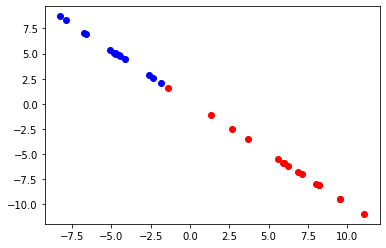

In [64]:
import matplotlib.pyplot as plt
fig=plt.figure()
for i in range(len(r)):
    plt.scatter(r[i][0],r[i][1], color='r' if y[i]==0 else 'b')
plt.show()